In [1]:
import os
#os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import quad_tri3, shape_fn_tri3
from femsolver.operator import FemOperator
from femsolver import jax_utils
import jax.numpy as jnp

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In [5]:
# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)



# --- Mesh ---
coords, elements = generate_unit_square_mesh_tri(10, 10)
n_nodes = coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$



In [3]:
# --- Material model (linear elasticity: plane strain) ---
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


def compute_stress(eps, mu=1.0, lmbda=1.0):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


def linear_elasticity_energy(grad_u, mu=1.0, lmbda=1.0):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


The femsolver provides a generic class `FemOperator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.

It takes three arguments:

- `compute_quads`: a function that returns the quadrature points and weights for the elements
- `compute_shape_fn`: a function that returns the shape functions for the elements
- `compute_energy`: a function that returns the energy density for the elements


In [4]:
fem = FemOperator(quad_tri3, shape_fn_tri3, linear_elasticity_energy)

In the above definition of the ``FemOperator`` class, we have used the ``quad_tri3`` and ``shape_fn_tri3`` functions to compute the quadrature points and shape functions for the triangular elements.

One can simply replace these two functions with any other quadrature and shape function. Just look at the ``quad_tri3`` and ``shape_fn_tri3`` functions in ``femsolver/quadrature.py`` to see how to define your own.

For more complex problems, one can define their own implementation of the `FemOperator` class. One just have to inherit from the `FemOperator` class and override the functions that are needed.


Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$

The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where 

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the energy-separation relationship. 

In [ ]:
def compute_fracture_energy(
    u_flat: jnp.ndarray, coords: jnp.ndarray, contact_nodes: jnp.ndarray
) -> jnp.ndarray:
    """
    Compute the contact energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]

    k_pen = 1e2
    node_area_weight = 1.0

    # Loop over nodes on the potential contact surface
    @jax_utils.vmap(in_axes=(0, 0))
    def contact_energy_node(u_node, x_node):
        gap = (x_node[0] + u_node[0]) - 0.0
        penetration = jnp.maximum(-gap, 0.0)
        return 0.5 * k_pen * (penetration**2) * node_area_weight

    return jnp.sum(contact_energy_node(u_nodes, x_nodes))


# --- Total energy ---
def total_energy(
    u_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    fem: FemOperator,
    contact_nodes: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        elements: Element indices.
        fem: FemOperator object.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    elastic_energy = jnp.sum(fem.integrate(u_cell, x_cell))

    # --- Contact energy ---
    contact_energy = compute_contact_energy(u_flat, coords, contact_nodes)

    return elastic_energy + contact_energy

In [ ]:
# define the displacement field
u = jnp.zeros(n_dofs)

# creating functions to compute the gradient and
# Hessian of the total energy using jax
grad_E = jax.grad(total_energy)
hess_E = jax.jacfwd(jax.grad(total_energy))

# --- Apply Dirichlet BCs ---
contact_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]


fixed_dofs = jnp.concatenate(
    [
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(-0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# compute the hessian which is the stiffness matrix
# and the gradient which is the internal force vector
K = hess_E(u, coords, elements, fem, contact_nodes)
f_int = grad_E(u, coords, elements, fem, contact_nodes)


# --- Solve for the displacement ---
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [25]:
# --- Compute von Mises stress ---
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# --- Compute von Mises stress per element ---
def compute_element_stress(coords, u, elements, fem):
    u_cells = u.reshape(-1,  n_dofs_per_node)[elements]
    coords_cells = coords[elements]

    def element_von_mises(u_e, x_e):
        qp, _ = quad_tri3()
        xi = qp[0]  # just take one point per element
        grad_u = fem.gradient(xi, u_e, x_e)
        eps = compute_strain(grad_u)
        sigma = compute_stress(eps)
        return von_mises_stress(sigma)

    return jax.vmap(element_von_mises)(u_cells, coords_cells)


# --- Visualization ---
from femsolver.plotting import STYLE_PATH

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    plt.figure(figsize=(5, 4))
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()


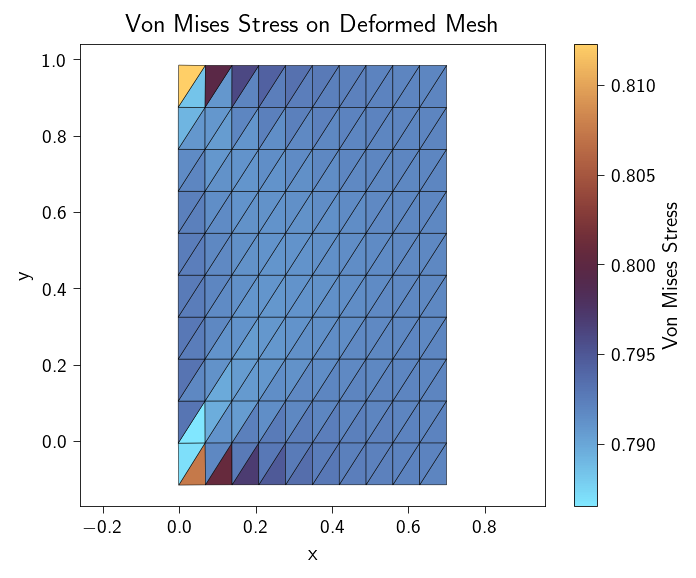

In [26]:
# --- Compute the stress ---    
u = u_full.reshape(-1, n_dofs_per_node)

stress_vm = compute_element_stress(coords, u, elements, fem)

# --- Plot the displacement and stress ---
plot_displacement_and_stress(coords, u, elements, stress_vm)